# **Color Magnification**

In this notebook we will learn how to reveal hidden color vairations in a video! This is called color magnfiication. 

In [1]:
import os
from glob import glob
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

%matplotlib inline

Get video path

Add your datapath here
You get download videos used for this tutorial [here](http://people.csail.mit.edu/mrub/evm/)

In [2]:
DATA_PATH = r"C:\Users\itber\Documents\learning\self_tutorials\phase_based\videos" # add your data path here

In [3]:
VIDEO_NAME = "face.mp4"

VIDEO_PATH = os.path.join(DATA_PATH, VIDEO_NAME)

os.path.exists(VIDEO_PATH)

True

## Set Hyperparameters

In [4]:
# video magnification factor
ALPHA = 50.0

# Gaussian Pyramid Level of which to apply magnfication?
LEVEL = 4

# Temporal Filter parameters
f_lo = 50/60
f_hi = 60/60

# OPTIONAL: override fs
MANUAL_FS = None
VIDEO_FS = None

# video frame scale factor
SCALE_FACTOR = 1.0

### Colorspace Functions

In [5]:
## Color spaces
def rgb2yiq(rgb):
    """ Converts an RGB image to YIQ using FCC NTSC format.
        This is a numpy version of the colorsys implementation
        https://github.com/python/cpython/blob/main/Lib/colorsys.py
        Inputs:
            rgb - (N,M,3) rgb image
        Outputs
            yiq - (N,M,3) YIQ image
        """
    # compute Luma Channel
    y = rgb @ np.array([[0.30], [0.59], [0.11]])

    # subtract y channel from red and blue channels
    rby = rgb[:, :, (0,2)] - y

    i = np.sum(rby * np.array([[[0.74, -0.27]]]), axis=-1)
    q = np.sum(rby * np.array([[[0.48, 0.41]]]), axis=-1)

    yiq = np.dstack((y.squeeze(), i, q))
    
    return yiq


def bgr2yiq(bgr):
    """ Coverts a BGR image to float32 YIQ """
    # get normalized YIQ frame
    rgb = np.float32(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
    yiq = rgb2yiq(rgb)

    return yiq


def yiq2rgb(yiq):
    """ Converts a YIQ image to RGB.
        Inputs:
            yiq - (N,M,3) YIQ image
        Outputs:
            rgb - (N,M,3) rgb image
        """
    r = yiq @ np.array([1.0, 0.9468822170900693, 0.6235565819861433])
    g = yiq @ np.array([1.0, -0.27478764629897834, -0.6356910791873801])
    b = yiq @ np.array([1.0, -1.1085450346420322, 1.7090069284064666])
    rgb = np.clip(np.dstack((r, g, b)), 0, 1)
    return rgb


inv_colorspace = lambda x: cv2.normalize(
    yiq2rgb(x), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)

#### Get Video Frames

In [6]:
frames = [] # frames for processing
cap = cv2.VideoCapture(VIDEO_PATH)

# video sampling rate
fs = cap.get(cv2.CAP_PROP_FPS)

idx = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break

    if idx == 0:
        og_h, og_w, _ = frame.shape
        w = int(og_w*SCALE_FACTOR)
        h = int(og_h*SCALE_FACTOR)

    # convert normalized uint8 BGR to the desired color space
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = bgr2yiq(np.float32(frame/255))

    # append resized frame
    frames.append(cv2.resize(frame, (w, h)))

    idx += 1
    
    
cap.release()
cv2.destroyAllWindows()
del cap

In [7]:
NUM_FRAMES = len(frames)
NUM_FRAMES

301

In [8]:
frames[0].min(axis=0).min(axis=0), frames[0].max(axis=0).max(axis=0)

(array([ 0.03937255, -0.12654472, -0.05871295]),
 array([0.99305882, 0.48281059, 0.19930981]))

Override sampling frequency

In [9]:
print(f"Detected Video Sampling rate: {fs}")

if MANUAL_FS:
    print(f"Overriding to: {MANUAL_FS}")
    fs = MANUAL_FS
    VIDEO_FS = fs
else:
    VIDEO_FS = fs

Detected Video Sampling rate: 30.0


## Get Temporal Filter

In [10]:
import scipy.signal as signal


bandpass = signal.firwin(numtaps=NUM_FRAMES,
                         cutoff=(f_lo, f_hi),
                         fs=fs,
                         pass_zero=False)

In [11]:
transfer_function = np.fft.fft(np.fft.ifftshift(bandpass))

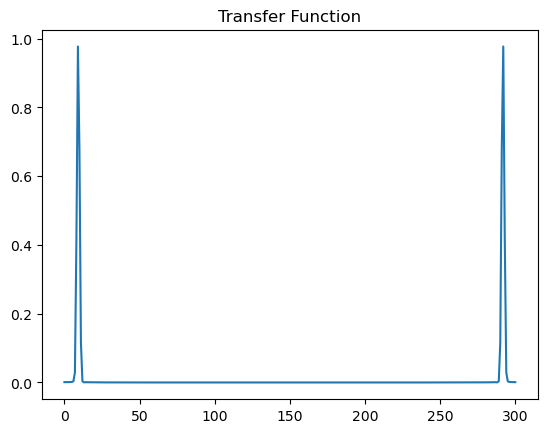

In [12]:
plt.plot(np.abs(transfer_function))
plt.title("Transfer Function");

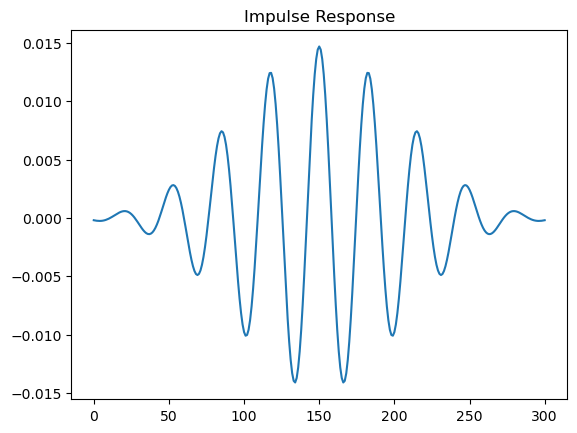

In [13]:
plt.plot(bandpass)
plt.title("Impulse Response");

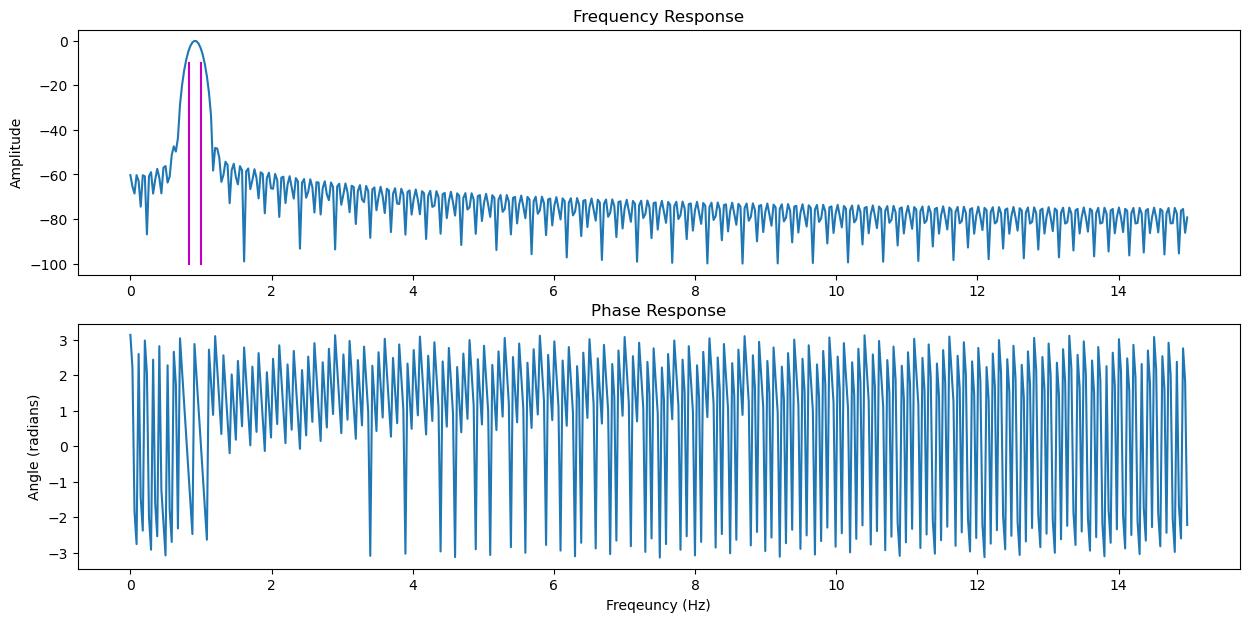

In [14]:
norm_freqs, response = signal.freqz(bandpass)
freqs = norm_freqs / np.pi * fs/ 2 

_, ax = plt.subplots(2, 1, figsize=(15, 7))
ax[0].plot(freqs, 20*np.log10(np.abs(response)));
ax[0].plot([f_lo, f_lo], [-100, -10], color='m')
ax[0].plot([f_hi, f_hi], [-100, -10], color='m')
ax[0].set_title("Frequency Response");
ax[0].set_ylabel("Amplitude");

ax[1].plot(freqs, np.angle(response));
ax[1].set_title("Phase Response");
ax[1].set_xlabel("Freqeuncy (Hz)");
ax[1].set_ylabel("Angle (radians)");

### Gaussian Pyramid

In [15]:
def gaussian_pyramid(image, level):
    """ Obtains single band of a Gaussian Pyramid Decomposition
        Inputs: 
            image - single channel input image
            num_levels - number of pyramid levels
        Outputs:
            pyramid - Pyramid decomposition tensor
        """ 
    rows, cols, colors = image.shape
    scale = 4*level
    pyramid = np.zeros((colors, rows//scale, cols//scale))

    for i in range(0, level):
        # image = cv2.pyrDown(image)

        image = cv2.pyrDown(image, dstsize=(cols//2, rows//2))
        rows, cols, _ = image.shape

        if i == (level - 1):
            for c in range(colors):
                pyramid[c, :, :] = image[:, :, c]

    return pyramid

In [16]:
rows, cols, colors = frames[0].shape
scale = 4*LEVEL
pyramid_stack = np.zeros((NUM_FRAMES, colors, rows//scale, cols//scale))

In [17]:
for i, frame in enumerate(frames):
    pyramid = gaussian_pyramid(frame, LEVEL)
    pyramid_stack[i, :, :, :] = pyramid

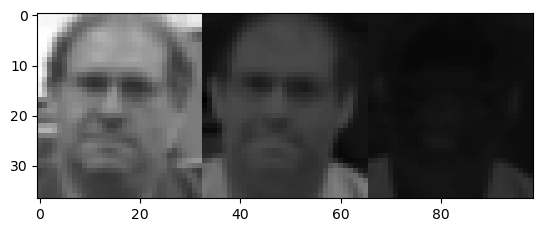

In [18]:
plt.imshow(pyramid_stack[0, :, :, :].transpose(1, 0, 2).reshape((pyramid.shape[1], -1)), cmap='gray');

#### Apply Temporal Filtering

In [377]:
pyr_stack_fft = np.fft.fft(pyramid_stack, axis=0).astype(np.complex64)
_filtered_pyramid = pyr_stack_fft * transfer_function[:, None, None, None].astype(np.complex64)
filtered_pyramid = np.fft.ifft(_filtered_pyramid, axis=0).real

In [378]:
pyr_stack_fft.shape

(301, 3, 37, 33)

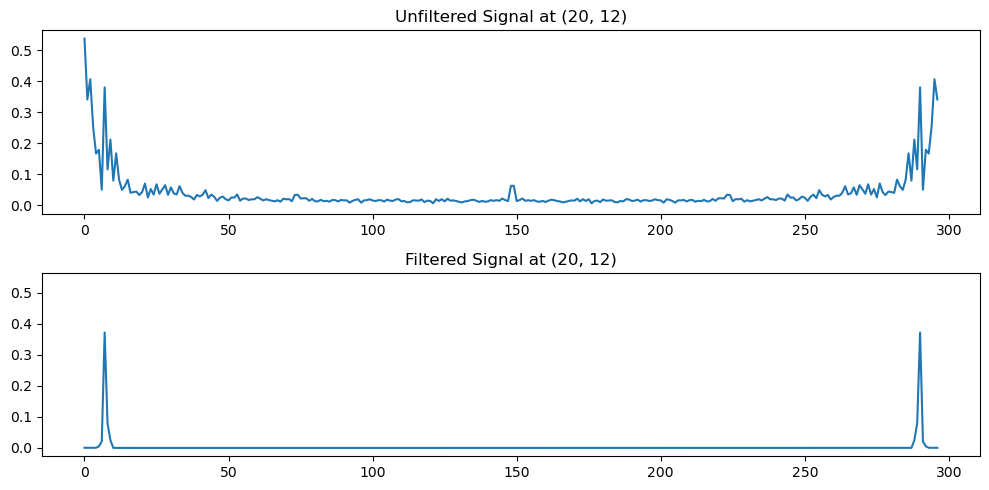

In [379]:
_, ax = plt.subplots(2, 1, figsize=(10, 5), sharey=True)

ax[0].plot(np.abs(pyr_stack_fft[2:-2, 0, 20, 12]))
ax[0].set_title("Unfiltered Signal at (20, 12)")

ax[1].plot(np.abs(_filtered_pyramid[2:-2, 0, 20, 12]))
ax[1].set_title("Filtered Signal at (20, 12)");

plt.tight_layout();

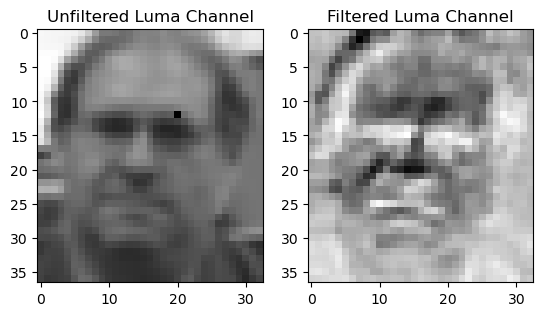

In [380]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(pyramid_stack[10, 0, :, :], cmap='gray')
ax[0].set_title("Unfiltered Luma Channel")
ax[1].imshow(filtered_pyramid[10, 0, :, :], cmap='gray')
ax[1].set_title("Filtered Luma Channel");

Display filtered results at single pixel

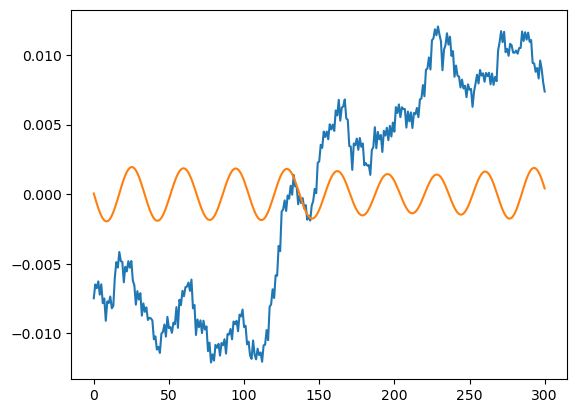

In [381]:
plt.plot(pyramid_stack[:, 0, 12, 20] - pyramid_stack[:, 0, 12, 20].mean())
plt.plot(filtered_pyramid[:, 0, 12, 20]);

## Apply Magnification and Reconstruct Video

In [383]:
magnified_pyramid = filtered_pyramid * ALPHA

In [384]:
magnified = []
magnified_only = []

for i in range(NUM_FRAMES):
    y_chan = frames[i][:, :, 0]
    i_chan = frames[i][:, :, 1] 
    q_chan = frames[i][:, :, 2] 
    
    fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
    fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
    fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

    # apply magnification
    mag = np.dstack((
        y_chan + fy_chan,
        i_chan + fi_chan,
        q_chan + fq_chan,
    ))
    
    # normalize and convert to RGB
    mag = inv_colorspace(mag)

    # store magnified frames
    magnified.append(mag)

    # store magified only for reference
    magnified_only.append(np.dstack((fy_chan, fi_chan, fq_chan)))

Check detected heart rates

In [385]:
og_reds = []
og_blues = []
og_greens = []

reds = []
blues = []
greens = []
for i in range(NUM_FRAMES):
    # convert YIQ to RGB
    frame = inv_colorspace(frames[i])
    og_reds.append(frame[0, :, :].sum())
    og_blues.append(frame[1, :, :].sum())
    og_greens.append(frame[2, :, :].sum())

    reds.append(magnified[i][0, :, :].sum())
    blues.append(magnified[i][1, :, :].sum())
    greens.append(magnified[i][2, :, :].sum())

In [386]:
times = np.arange(0, NUM_FRAMES)/fs

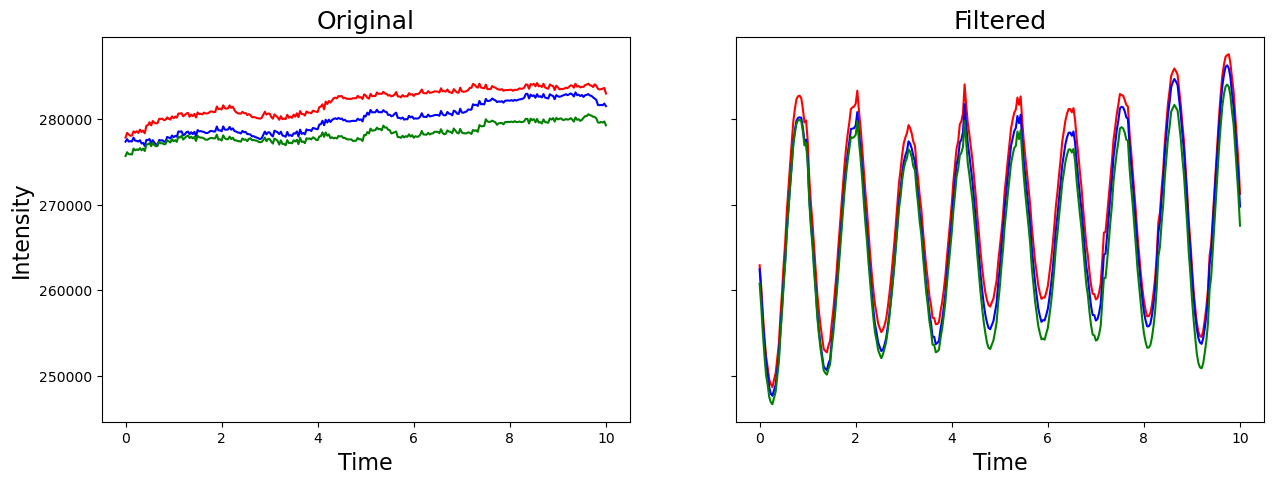

In [387]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax[0].plot(times, og_reds, color='red')
ax[0].plot(times, og_blues, color='blue')
ax[0].plot(times, og_greens, color='green')
ax[0].set_title("Original", size=18)
ax[0].set_xlabel("Time", size=16)
ax[0].set_ylabel("Intensity", size=16)

ax[1].plot(times, reds, color='red')
ax[1].plot(times, blues, color='blue')
ax[1].plot(times, greens, color='green')
ax[1].set_title("Filtered", size=18)
ax[1].set_xlabel("Time", size=16);

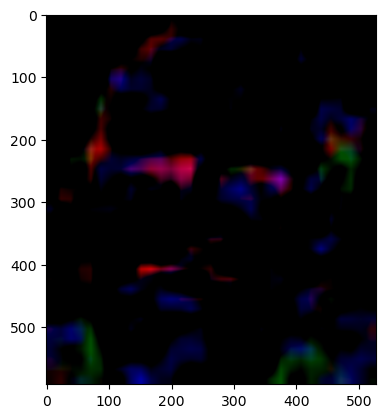

In [388]:
plt.imshow(yiq2rgb(magnified_only[10])*10)

In [389]:
freqs = np.fft.rfftfreq(NUM_FRAMES) * fs
rates = np.abs(np.fft.rfft(reds))/NUM_FRAMES

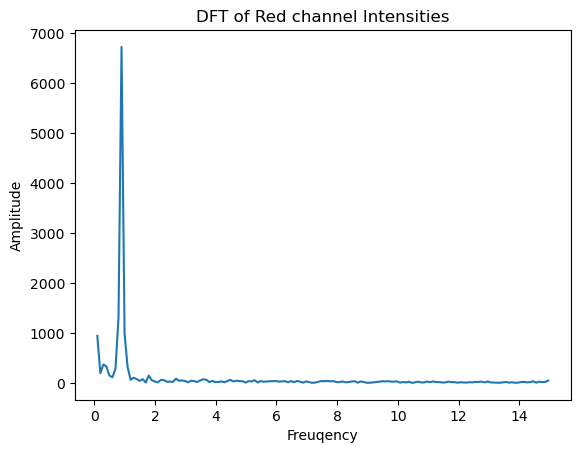

In [390]:
plt.plot(freqs[1:], rates[1:]);
plt.title("DFT of Red channel Intensities")
plt.xlabel("Freuqency")
plt.ylabel("Amplitude");

find peak

In [391]:
peak_idx, _ = signal.find_peaks(rates, height=1000)

In [392]:
freqs[peak_idx], rates[peak_idx]

(array([0.89700997]), array([6726.61757753]))

## Make a video

In [186]:
stacked_frames = []
middle = np.zeros((rows, 3, 3)).astype(np.uint8)

for vid_idx in range(NUM_FRAMES):
    og_frame = cv2.normalize(yiq2rgb(frames[vid_idx]), None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)
    frame = np.hstack((cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR), 
                       middle, 
                       cv2.cvtColor(magnified[vid_idx], cv2.COLOR_RGB2BGR)))
    stacked_frames.append(frame)

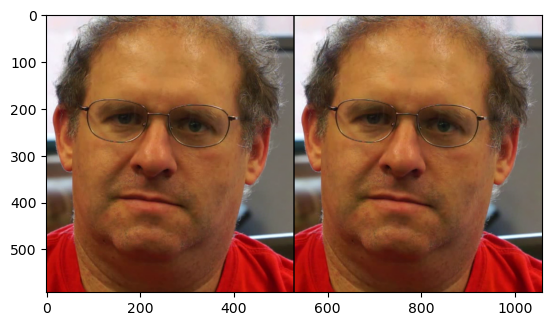

In [187]:
plt.imshow(cv2.cvtColor(stacked_frames[10], cv2.COLOR_BGR2RGB));

In [188]:
# get width and height for video frames
_h, _w, _ = stacked_frames[-1].shape

# save to mp4
out = cv2.VideoWriter(f"stacked_IIR_{int(ALPHA)}x.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      int(fs), 
                      (_w, _h))
 
for frame in stacked_frames:
    out.write(frame)

out.release()
del out

Create a video of the magnified only frames

In [165]:
# get width and height for video frames
_h, _w, _ = magnified_only[-1].shape

# save to mp4
out = cv2.VideoWriter(f"stacked_{int(ALPHA)}x_AMP.mp4",
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      int(fs), 
                      (_w, _h))

sums = []
for frame in magnified_only:
    sums.append(frame.sum(axis=1).sum(axis=0))
    
    frame = cv2.cvtColor(
        cv2.normalize(frame*20, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1),
        cv2.COLOR_RGB2BGR)
    out.write(frame)

    

out.release()
del out

Create GIF

In [204]:
h, w, _ = stacked_frames[0].shape

In [205]:
h2 = np.round(h/2.5).astype(int)
w2 = np.round(w/2.5).astype(int)

In [206]:
from PIL import Image 


# accumulate PIL image objects
pil_images = []
for img in stacked_frames:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, dsize=(w2, h2))
    pil_images.append(Image.fromarray(img))

# create GIF
pil_images[0].save(f"stacked_{int(ALPHA)}x.gif", 
                    format="GIF", 
                    append_images=pil_images, 
                    save_all=True, 
                    duration=50, # duration that each frame is displayed
                    loop=0)

## Visualize Amplification

In [171]:
stacked = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in stacked_frames])

In [172]:
frame.shape

(592, 528, 3)

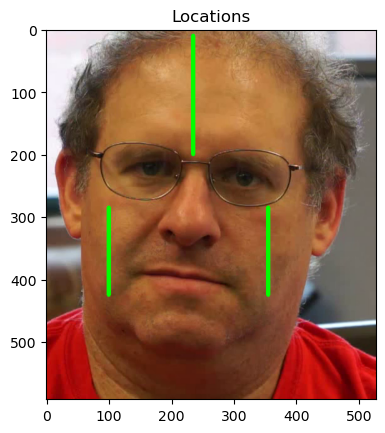

In [173]:
frame = stacked[0, :, :, :].copy()[:, :og_w, :]

forehead_idx = 235
lcheek_idx = 100
rcheek_idx = 355

cv2.line(frame, (forehead_idx, 10), (forehead_idx, 200), (0,255,0), 5)
cv2.line(frame, (lcheek_idx, 285), (lcheek_idx, 425), (0,255,0), 5)
cv2.line(frame, (rcheek_idx, 285), (rcheek_idx, 425), (0,255,0), 5)

plt.imshow(frame);
plt.title("Locations");

In [174]:
idx1 = 220 
idx2 = idx1 + og_w + 3

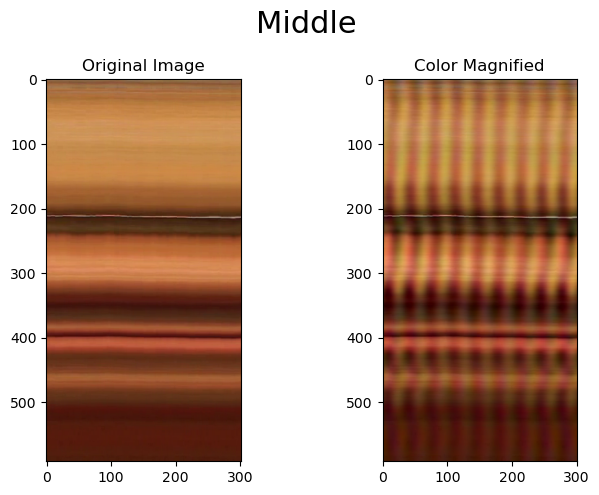

In [175]:
fig, ax = plt.subplots(1, 2, figsize=(7,5))
fig.suptitle("Middle", size=22)
ax[0].imshow(stacked[:, :, idx1, :].transpose(1, 0, 2))
ax[0].set_title("Original Image")
ax[1].imshow(stacked[:, :, idx2, :].transpose(1, 0, 2))
ax[1].set_title("Color Magnified");

plt.tight_layout();

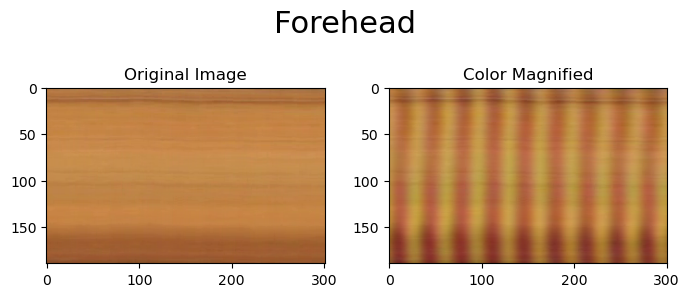

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(7,3))
fig.suptitle("Forehead", size=22)
ax[0].imshow(stacked[:, 10:200, forehead_idx, :].transpose(1, 0, 2))
ax[0].set_title("Original Image")
ax[1].imshow(stacked[:, 10:200, forehead_idx + og_w + 3, :].transpose(1, 0, 2))
ax[1].set_title("Color Magnified");

plt.tight_layout();

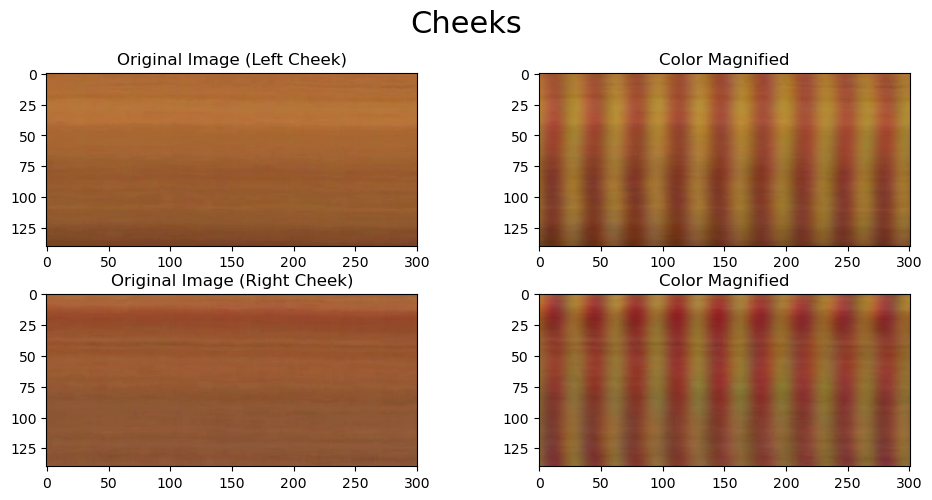

In [177]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Cheeks", size=22)
ax[0, 0].imshow(stacked[:, 285:425, lcheek_idx, :].transpose(1, 0, 2))
ax[0, 0].set_title("Original Image (Left Cheek)")
ax[0, 1].imshow(stacked[:, 285:425, lcheek_idx + og_w + 3, :].transpose(1, 0, 2))
ax[0, 1].set_title("Color Magnified");
ax[1, 0].imshow(stacked[:, 285:425, rcheek_idx, :].transpose(1, 0, 2))
ax[1, 0].set_title("Original Image (Right Cheek)")
ax[1, 1].imshow(stacked[:, 285:425, rcheek_idx + og_w + 3, :].transpose(1, 0, 2))
ax[1, 1].set_title("Color Magnified");

plt.tight_layout();

In [229]:


frames = [] # frames for processing
cap = cv2.VideoCapture(VIDEO_PATH)

# video sampling rate
fs = cap.get(cv2.CAP_PROP_FPS)

idx = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break

    if idx == 0:
        og_h, og_w, _ = frame.shape
        w = int(og_w*SCALE_FACTOR)
        h = int(og_h*SCALE_FACTOR)

    # convert normalized uint8 BGR to the desired color space
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)/255
    # frame = bgr2yiq(np.float32(frame/255))

    # append resized frame
    frames.append(cv2.resize(frame, (w, h)))

    idx += 1
    
    
cap.release()
cv2.destroyAllWindows()
del cap

In [244]:
def mag_colors(rgb_frames, fs, freq_lo, freq_hi, level, alpha):
    """ Function to obtain Amplified Colors in a given list of RGB frames 
        Inputs:
            rgb_frames - list of RGB video frames
            fs - sample frequency
            freq_lo - lower frequency bound
            freq_hi - upper frequency bound
            level - level of Gaussian Pyramid
            alpha - magnification factor
        Outputs:
            magnified_frames - COlor magnified RGB video frames
    """
    rows, cols, colors = rgb_frames[0].shape
    num_frames = len(rgb_frames)

    # convert frames to YIQ colorspace
    # frames = [rgb2yiq(frame) for frame in rgb_frames]
    frames = rgb_frames

    ## Get Temporal Filter
    bandpass = signal.firwin(numtaps=num_frames,
                             cutoff=(freq_lo, freq_hi),
                             fs=fs,
                             pass_zero=False)
    
    transfer_function = np.fft.fft(np.fft.ifftshift(bandpass))
    transfer_function = transfer_function[:, None, None, None].astype(np.complex64)

    ## Get Gaussian Pyramid Stack
    scale = 2**level
    pyramid_stack = np.zeros((num_frames, colors, rows//scale, cols//scale))
    for i, frame in enumerate(frames):
        pyramid = gaussian_pyramid(frame, level)
        pyramid_stack[i, :, :, :] = pyramid

    ## Apply Temporal Filtering
    pyr_stack_fft = np.fft.fft(pyramid_stack, axis=0).astype(np.complex64)
    _filtered_pyramid = pyr_stack_fft * transfer_function
    filtered_pyramid = np.fft.ifft(_filtered_pyramid, axis=0).real

    ## Apply magnification to video
    magnified_pyramid = filtered_pyramid * alpha

    ## Collapse Pyramid and reconstruct video
    magnified = []

    for i in range(num_frames):
        y_chan = frames[i][:, :, 0] 
        i_chan = frames[i][:, :, 1] 
        q_chan = frames[i][:, :, 2] 
        
        fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
        fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
        fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

        # apply magnification
        mag = np.dstack((
            y_chan + fy_chan,
            i_chan + fi_chan,
            q_chan + fq_chan,
        ))

        # convert to RGB and normalize
        # mag = inv_colorspace(mag)

        # mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)

        # store magnified frames
        magnified.append(mag)

    return magnified

results = mag_colors(frames, fs, f_lo, f_hi, level=4, alpha=75)

In [258]:
def mag_colors(rgb_frames, fs, freq_lo, freq_hi, level, alpha):
    """ Function to obtain Amplified Colors in a given list of RGB frames 
        Inputs:
            rgb_frames - list of RGB video frames
            fs - sample frequency
            freq_lo - lower frequency bound
            freq_hi - upper frequency bound
            level - level of Gaussian Pyramid
            alpha - magnification factor
        Outputs:
            magnified_frames - COlor magnified RGB video frames
    """
    rows, cols, colors = rgb_frames[0].shape
    num_frames = len(rgb_frames)

    # convert frames to YIQ colorspace
    frames = [rgb2yiq(frame) for frame in rgb_frames]

    ## Get Temporal Filter
    bandpass = signal.firwin(numtaps=num_frames,
                             cutoff=(freq_lo, freq_hi),
                             fs=fs,
                             pass_zero=False)
    
    transfer_function = np.fft.fft(np.fft.ifftshift(bandpass))
    transfer_function = transfer_function[:, None, None, None].astype(np.complex64)

    ## Get Gaussian Pyramid Stack
    scale = 2**level
    pyramid_stack = np.zeros((num_frames, colors, rows//scale, cols//scale))
    for i, frame in enumerate(frames):
        pyramid = gaussian_pyramid(frame, level)
        pyramid_stack[i, :, :, :] = pyramid

    ## Apply Temporal Filtering
    pyr_stack_fft = np.fft.fft(pyramid_stack, axis=0).astype(np.complex64)
    _filtered_pyramid = pyr_stack_fft * transfer_function
    filtered_pyramid = np.fft.ifft(_filtered_pyramid, axis=0).real

    ## Apply magnification to video
    magnified_pyramid = filtered_pyramid * alpha

    ## Collapse Pyramid and reconstruct video
    magnified = []

    for i in range(num_frames):
        y_chan = frames[i][:, :, 0] 
        i_chan = frames[i][:, :, 1] 
        q_chan = frames[i][:, :, 2] 
        
        fy_chan = cv2.resize(magnified_pyramid[i, 0, :, :], (cols, rows))
        fi_chan = cv2.resize(magnified_pyramid[i, 1, :, :], (cols, rows))
        fq_chan = cv2.resize(magnified_pyramid[i, 2, :, :], (cols, rows))

        # apply magnification
        mag = np.dstack((
            y_chan + fy_chan,
            i_chan + fi_chan,
            q_chan + fq_chan,
        ))

        # convert to RGB and normalize
        mag = inv_colorspace(mag)

        # store magnified frames
        magnified.append(mag)

    return magnified


results = mag_colors(frames, fs, f_lo, f_hi, level=4, alpha=75)

In [254]:
tmp = cv2.normalize(results[10], None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32FC3)
tmp = cv2.normalize(results[10], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC3)

In [261]:
frames[0]

array([[[0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        ...,
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451]],

       [[0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        ...,
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451]],

       [[0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        [0.94901961, 0.9254902 , 0.95294118],
        ...,
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451],
        [0.89803922, 0.84705882, 0.88627451]],

       ...,

       [[0.74509804, 0.05882353, 0.05098039],
        [0.74117647, 0.05490196, 0.04705882],
        [0.74117647, 0

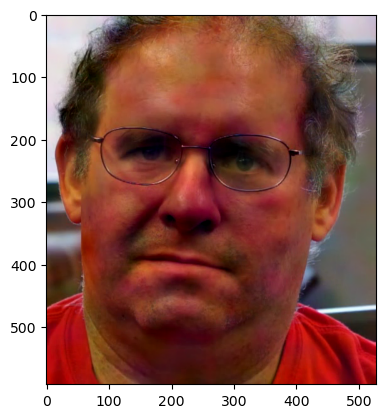

In [260]:
plt.imshow(results[10])

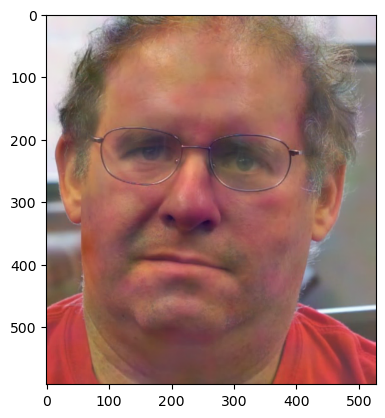

In [257]:
plt.imshow(tmp/255)

In [246]:
for frame in results:
    print(frame.min(), frame.max())

-0.1931065999612327 1.0564475989735358
-0.21553292861314166 1.0930967042494846
-0.23264068233930954 1.1218282636976749
-0.2398508077610196 1.1446318928615282
-0.2439825780044352 1.1476823170694854
-0.2760015763866295 1.1494229923500394
-0.2981536030885914 1.131317054033619
-0.30963046867155486 1.100376392063653
-0.3100292643858481 1.0562604544426515
-0.2993631513162215 1.0176361691904219
-0.2780649861686936 1.0044442078609177
-0.24696668928142376 1.0074985351318877
-0.20726218308416836 1.0088545888195606
-0.1604611173470392 1.0309042127041272
-0.11549828157047336 1.0504459182018426
-0.07856466415559932 1.0661448703900505
-0.07437208442326808 1.0734021877837843
-0.09021978493246413 1.0834898233541683
-0.10912004292352513 1.088538341412631
-0.1290573385924038 1.1015069717536774
-0.15054343432877237 1.1055341284773734
-0.14184934393644158 1.0981047067918466
-0.13732212727717563 1.0882752531372235
-0.12465353380898807 1.073020553583104
-0.1097350651946448 1.0659360917697518
-0.096069861908